# Импорт библиотек

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from transformers import ViTForImageClassification
from transformers import ViTConfig, ViTForImageClassification
from datasets import load_dataset
from datasets import Dataset
from torch.utils.data import  Subset
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
import torch.optim as optim
from torchvision import models, transforms, datasets
from torchvision.models import resnet34, ResNet34_Weights
import torchvision.models as models

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DF = pd.read_excel('/content/data_8_30160 (копия).xlsx')
DF['id'] = DF['id'].fillna('').astype(str)
DF.to_excel('data_8_new.xlsx', index = False)

# Загрузка данных

In [5]:
data = pd.read_excel("/content/data_8_new.xlsx")
data= Dataset.from_pandas(data)
data

Dataset({
    features: ['id', 'IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH'],
    num_rows: 3288
})

# Распределение по классам биомаркеров

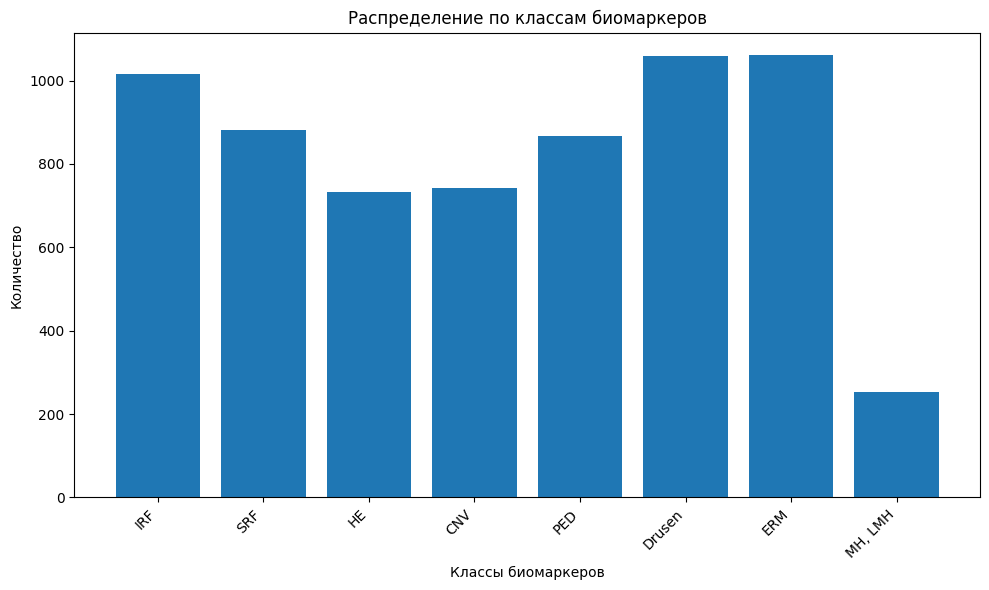

In [6]:
dataset_no_id = data.remove_columns(["id"]) # Создаем новый Dataset без 'id'

labels = ['IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH']
def plot_histogram(data_split):
        if not isinstance(data_split, Dataset):
            raise TypeError("data_split must be a Dataset object.")

        class_counts = {
            label: 0 for label in labels
        }

        for i in range(len(data_split)):
            sample = data_split[i]

            for label in labels:
                try:
                    class_counts[label] += sample[label]
                except KeyError as e:
                    print(f"KeyError: {e}. Обратите внимание на структуру данных.")
                    return

        classes = list(class_counts.keys())
        counts = list(class_counts.values())

        plt.figure(figsize=(10, 6))
        plt.bar(classes, counts)
        plt.xlabel('Классы биомаркеров')
        plt.ylabel('Количество')
        plt.title('Распределение по классам биомаркеров')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

plot_histogram(dataset_no_id)


# Совместное рапределение биомаркеров

In [7]:
from collections import defaultdict
def plot_combined_biomarkers(data_split):
    biomarkers_pairs = defaultdict(int)

    for entry in data_split:
        biomarkers = {key: value for key, value in entry.items() if key in labels}
        active_biomarkers = [biomarkers for biomarkers, value in biomarkers.items() if value > 0]

        for pair in itertools.combinations(sorted(active_biomarkers), 2):
            biomarkers_pairs[pair] += 1

    sorted_pairs = sorted(biomarkers_pairs.items(), key=lambda x: x[1], reverse=True)
    pairs = [f"{pair[0]} & {pair[1]}" for pair, _ in sorted_pairs]
    counts = [count for _, count in sorted_pairs]

    plt.figure(figsize=(18, 6))
    plt.bar(pairs[:20], counts[:20])
    plt.xlabel('Пары биомаркеров')
    plt.ylabel('Количество')
    plt.title('Совместное появление биомаркеров')
    plt.xticks(rotation=45)

    plt.show()


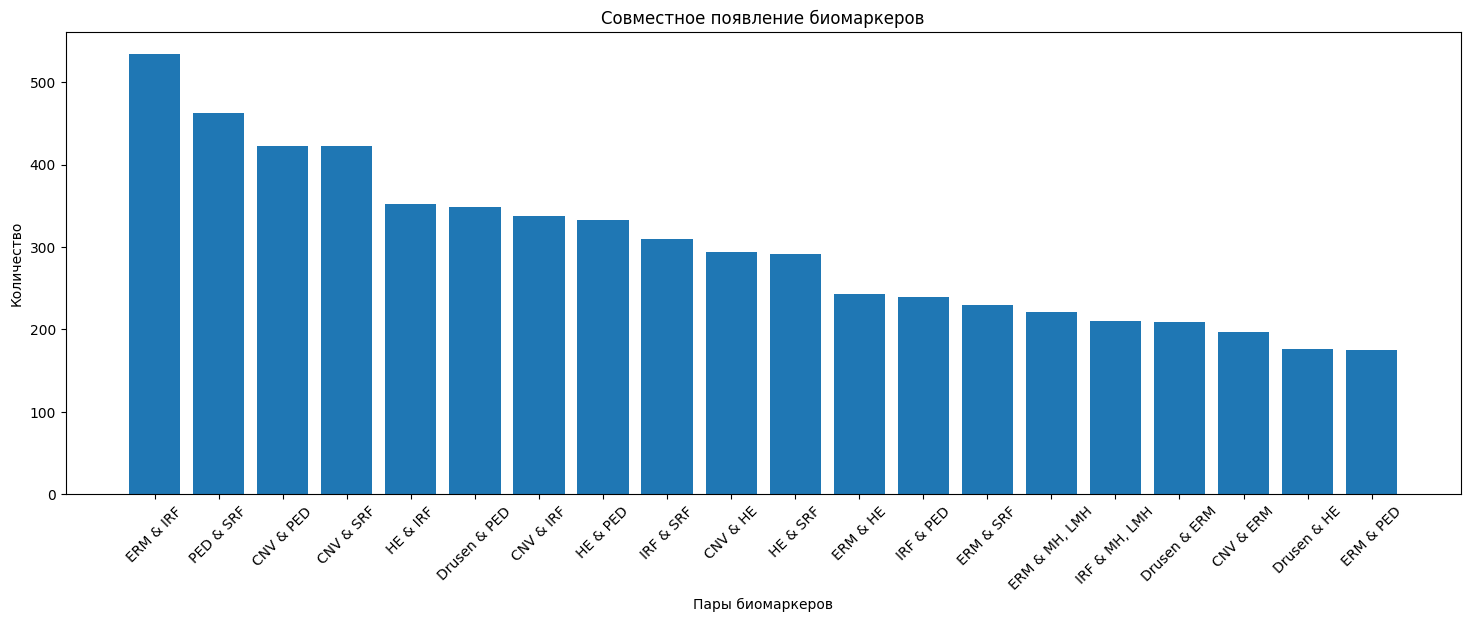

In [ ]:
plot_combined_biomarkers(dataset_no_id)

  # Предварительная обработка данных

In [8]:
# Custom DataLoader
class CustomDataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = list(range(len(dataset)))
        if shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):
        if self.i >= len(self.indices):
            raise StopIteration

        batch_indices = self.indices[self.i:self.i + self.batch_size]
        self.i += self.batch_size

        batch = [self.dataset[idx] for idx in batch_indices]

        images = [item[0] for item in batch]
        labels = [item[1] for item in batch]


        images = torch.stack(images)
        labels = torch.stack(labels)

        return images, labels, #img_name

    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size

In [9]:
class OCTDataset(Dataset):
    def __init__(self, images_dir, labels_file, transform=None):
        """
        Args:
            images_dir (string): Directory with all the images.
            labels_file (string): Path to the XLSX file with labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images_dir = images_dir
        self.labels_df = pd.read_excel(labels_file)
        self.labels_df['id'] = self.labels_df['id'].astype(str)
        self.transform = transform
        self.valid_indices = self._find_valid_indices()
    def _find_valid_indices(self):
        """
        Find indices for which image files exist
        """
        valid_indices = []
        for idx in range(len(self.labels_df)):
            img_name = os.path.join(self.images_dir, f"{self.labels_df['id'].iloc[idx]}.jpg")
            if os.path.exists(img_name):
                valid_indices.append(idx)
        return valid_indices


    def __len__(self):
        return len(self.valid_indices)
    def __getitem__(self, idx):

        real_idx = self.valid_indices[idx]
        img_name = os.path.join(self.images_dir, f"{self.labels_df['id'].iloc[real_idx]}.jpg")

        try:
            image = Image.open(img_name).convert('RGB')
        except FileNotFoundError:
            print(f"Error: File not found at {img_name}")

            image = Image.new('RGB', (224, 224), color='black')
            labels = torch.zeros(12, dtype=torch.float32)
            if self.transform:
                image = self.transform(image)
            return image, labels

        labels = torch.tensor(self.labels_df[['IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH']].iloc[real_idx].values, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, labels, img_name

In [10]:
data_transforms = transforms.Compose([
    transforms.Resize(180),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
data_transforms_train = transforms.Compose([
    transforms.Resize(180),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
    transforms.ToTensor(),
    #transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

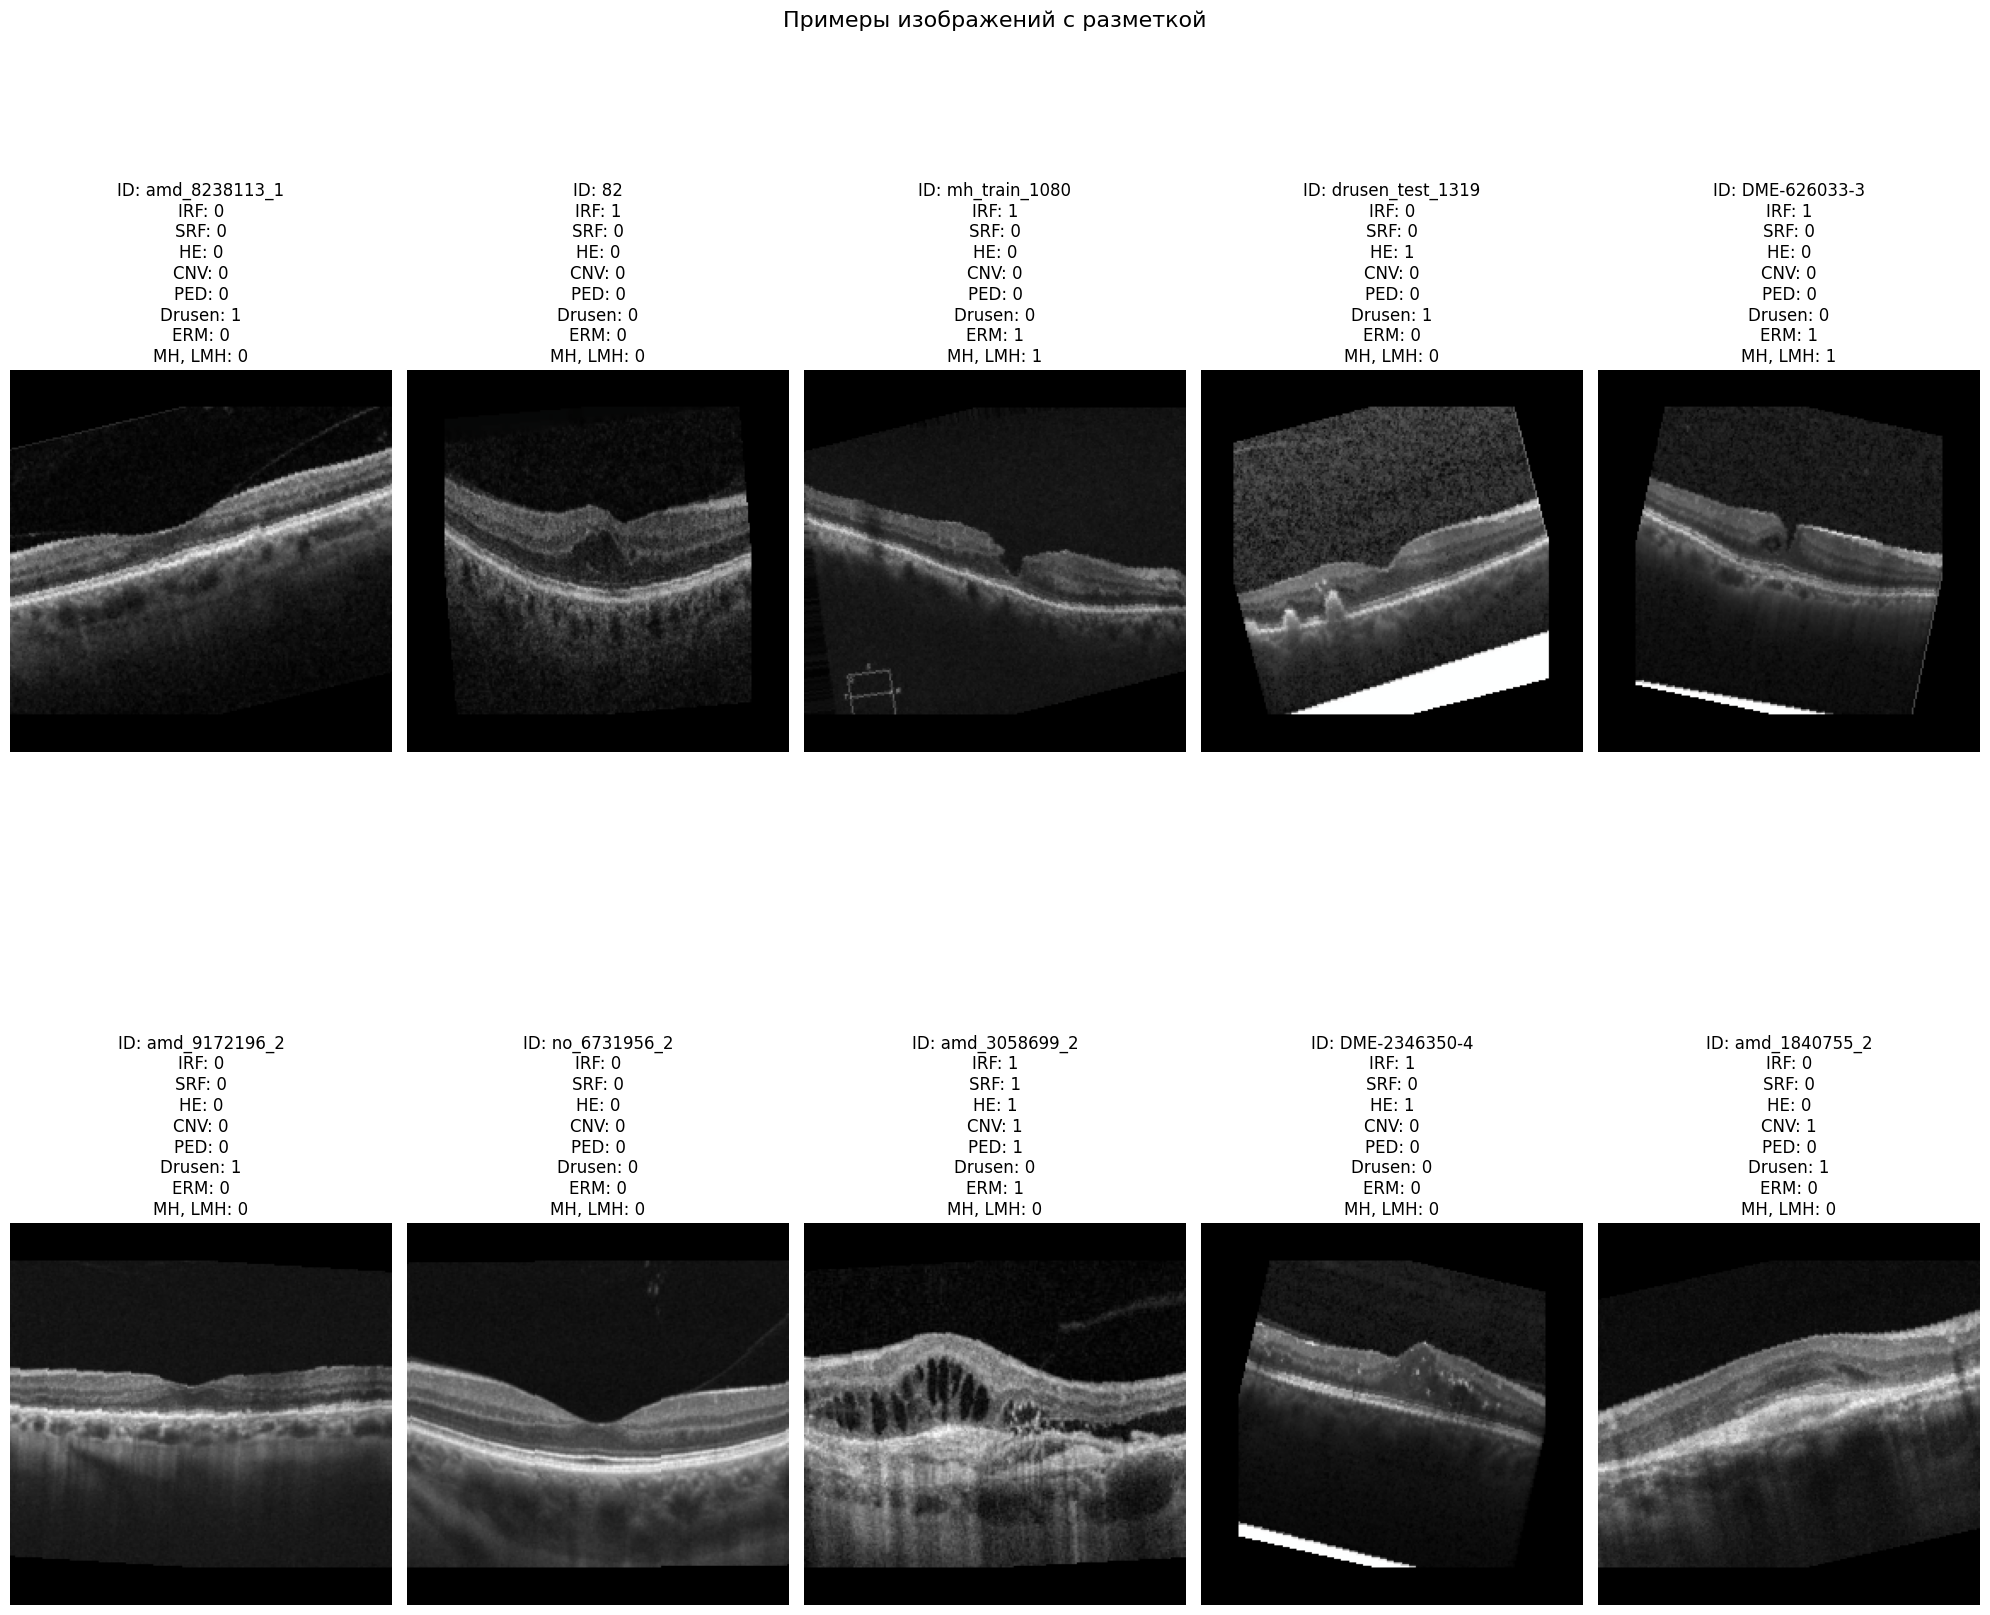

In [12]:
# Создаем датасет с вашими трансформациями
dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/data_jpg1',
    labels_file='/content/data_8_new.xlsx',
    transform=data_transforms_train  # ваши трансформы из предыдущего кода
)
# Выбираем 10 случайных индексов
indices = torch.randperm(len(dataset))[:10]

# Функция для денормализации изображения
def denormalize(image):
    """Денормализует изображение для отображения"""
    if isinstance(image, torch.Tensor):
        image = image.numpy()

    # Транспонируем из (C, H, W) в (H, W, C)
    image = image.transpose(1, 2, 0)

    # Параметры нормализации ImageNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    image = std * image + mean  # Денормализация
    image = np.clip(image, 0, 1)  # Ограничиваем значения [0, 1]
    return image

# Создаем grid для отображения
fig, axes = plt.subplots(2, 5, figsize=(20, 20))
fig.suptitle('Примеры изображений с разметкой', fontsize=16)

for i, idx in enumerate(indices):
    image, label, name = dataset[idx]

    # Денормализуем изображение
    image = denormalize(image)

    # Получаем метки
    label_names = ['IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH']
    label_text = '\n'.join([f'{n}: {v:.0f}' for n, v in zip(label_names, label.numpy())])

    # Отображаем
    ax = axes[i//5, i%5]
    ax.imshow(image)
    ax.set_title(f"ID: {dataset.labels_df['id'].iloc[dataset.valid_indices[idx]]}\n{label_text}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
# Создаем индексы для разделения
dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/data_jpg1',
    labels_file='/content/data_8_new.xlsx',
    transform=None  # Временно ставим None
)

train_size = 0.9
test_size = 0.1

train_idx, test_idx = train_test_split(
    np.arange(len(dataset)),
    test_size=test_size,
    train_size=train_size,
    random_state=42
)

# Создаем отдельные датасеты с разными трансформациями
train_dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/data_jpg1',
    labels_file='/content/data_8_new.xlsx',
    transform=data_transforms_train  # Применяем train-трансформации
)
train_dataset = Subset(train_dataset, train_idx) #фильтруем по индексам

test_dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/data_jpg1',
    labels_file='/content/data_8_new.xlsx',
    transform=data_transforms  # Применяем test-трансформации
)
test_dataset = Subset(test_dataset, test_idx) #фильтруем по индексам


# Проверяем размеры
print(f"Размер тренировочного набора: {len(train_dataset)}")
print(f"Размер тестового набора: {len(test_dataset)}")

# Пример использования DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)



Размер тренировочного набора: 2925
Размер тестового набора: 325


In [14]:
# Create CUSTOM data loaders
train_dataloader = CustomDataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True)

test_dataloader = CustomDataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False)

#Обучение модели.

## Загрузка весов модели

In [15]:
from transformers import ViTConfig, ViTForImageClassification
from huggingface_hub import hf_hub_download
import argparse

In [16]:
from transformers import ViTForImageClassification
from huggingface_hub import hf_hub_download
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score



# 1. Настройка
repo_id = "WinKawaks/vit-tiny-patch16-224"
num_labels = 8

# 2. Загрузка модели
model = ViTForImageClassification.from_pretrained(
    repo_id,
    num_labels=num_labels,
    ignore_mismatched_sizes=True #  изменяем колличество классов
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([8, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Обучение и оценка модели

In [17]:
import torch.nn as nn

def train_epoch(model, dataloader, criterion, optimizer, device, threshold=0.35):
    model.train()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images).logits  # Get logits from ViTForImageClassification

        # The criterion expects logits as input
        loss = criterion(outputs, labels.float())  # Pass labels as float for BCEWithLogitsLoss


        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        # Apply sigmoid to outputs and threshold
        probs = torch.sigmoid(outputs)
        predicted_classes = (probs > threshold).cpu().numpy()
        true_classes = labels.cpu().numpy()

        all_labels.extend(true_classes)
        all_predictions.extend(predicted_classes)

    avg_loss = total_loss / len(dataloader)
    return avg_loss, all_labels, all_predictions

In [18]:
def eval_epoch(model, dataloader, criterion, device, threshold=0.35):
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images).logits  # Get logits from ViTForImageClassification

            # The criterion expects logits as input
            loss = criterion(outputs, labels.float())  # Pass labels as float for BCEWithLogitsLoss

            total_loss += loss.item()

             # Apply sigmoid to outputs and threshold
            probs = torch.sigmoid(outputs)
            predicted_classes = (probs > threshold).cpu().numpy()
            true_classes = labels.cpu().numpy()

            all_labels.extend(true_classes)
            all_predictions.extend(predicted_classes)

    avg_loss = total_loss / len(dataloader)
    return avg_loss, all_labels, all_predictions

In [23]:
num_epochs = 1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-9) # Adjust optimizer and learning rate!
criterion = torch.nn.BCEWithLogitsLoss()
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')

    # Train


    train_loss, train_labels, train_predictions = train_epoch(model, train_dataloader, criterion, optimizer, device)
    train_labels = np.array(train_labels).astype(np.int32)
    train_labels = np.where(train_labels > 1, 1, train_labels)
    train_predictions = np.array(train_predictions).astype(np.int32)
    train_accuracy = accuracy_score(train_labels, train_predictions)
    train_precision = precision_score(train_labels, train_predictions, average='macro', zero_division=0)
    train_recall = recall_score(train_labels, train_predictions, average='macro', zero_division=0)
    train_f1 = f1_score(train_labels, train_predictions, average='macro', zero_division=0)

    print(f'Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}')


    # Validation
    val_loss, val_labels, val_predictions = eval_epoch(model, test_dataloader, criterion, device)

    # Calculate metrics for each class
    precision, recall, f1, support = precision_recall_fscore_support(
        val_labels, val_predictions, average=None, zero_division=0
    )
    print(f'Val loss{val_loss:.2f}')
    f1_val_macro = f1_score(val_labels, val_predictions, average='macro', zero_division=0)
    f1_val_micro = f1_score(val_labels, val_predictions, average='micro', zero_division=0)
    print(f'f1_macro{f1_val_macro:.2f}, f1_micro{f1_val_micro:.2f}')

print("Training complete")

Epoch 1/1
Train Loss: 0.0925, Accuracy: 0.7826, Precision: 0.9297, Recall: 0.9438, F1: 0.9365
Val loss0.21
f1_macro0.84, f1_micro0.83
Training complete


In [24]:
num_classes_present = len(precision) # Get the actual number of classes present
for i in range(num_classes_present):
    print(f'Class {i}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.2f}, F1 = {f1[i]:.2f}, Support = {support[i]}')



Class 0: Precision = 0.8889, Recall = 0.92, F1 = 0.90, Support = 87
Class 1: Precision = 0.8556, Recall = 0.86, F1 = 0.86, Support = 90
Class 2: Precision = 0.7826, Recall = 0.76, F1 = 0.77, Support = 71
Class 3: Precision = 0.8000, Recall = 0.88, F1 = 0.84, Support = 77
Class 4: Precision = 0.8152, Recall = 0.88, F1 = 0.85, Support = 85
Class 5: Precision = 0.9176, Recall = 0.76, F1 = 0.83, Support = 102
Class 6: Precision = 0.8889, Recall = 0.67, F1 = 0.76, Support = 108
Class 7: Precision = 0.8636, Recall = 1.00, F1 = 0.93, Support = 19


In [ ]:
torch.save(model.state_dict(), 'model34_8_1.pth')
print("Модель сохранена в model.pth")

Модель сохранена в model.pth


# Проверка на Валидационном наборе

In [25]:
val_dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/ОКТ макула (копия)',
    labels_file='/content/OCT_VAL 8.xlsx',
    transform=data_transforms
)

val_dataloader = CustomDataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False)


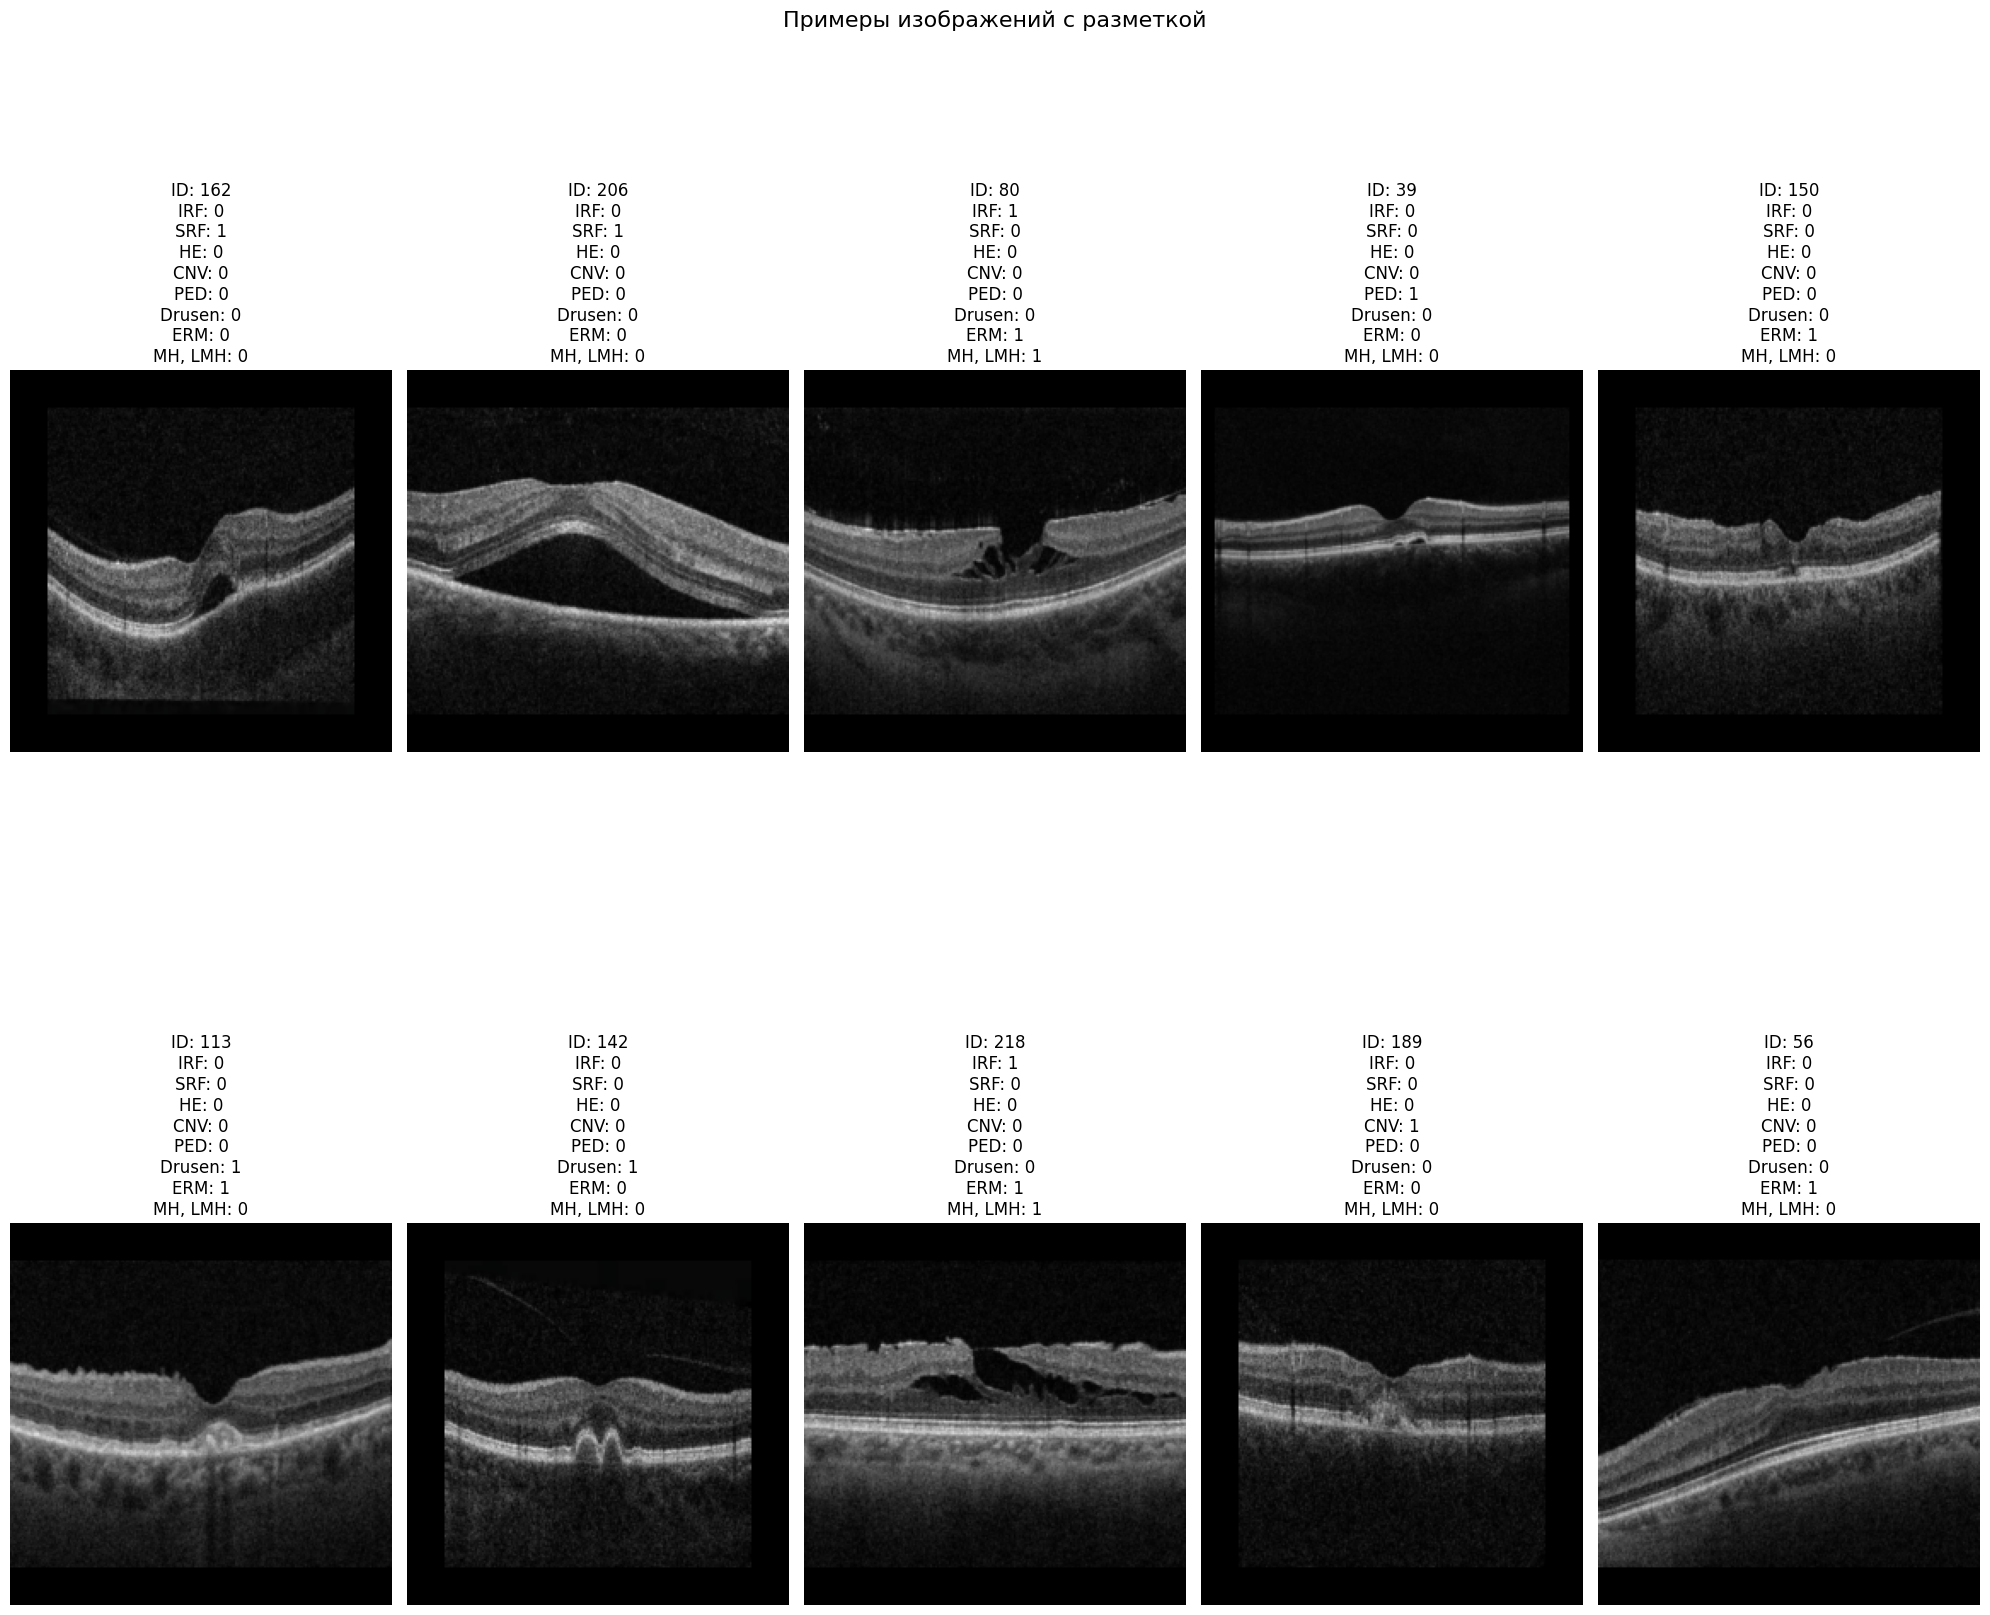

In [26]:
# Выбираем 10 случайных индексов
indices = torch.randperm(len(val_dataset))[:10]

# Создаем grid для отображения
fig, axes = plt.subplots(2, 5, figsize=(20, 20))
fig.suptitle('Примеры изображений с разметкой', fontsize=16)

for i, idx in enumerate(indices):
    image, label,name = val_dataset[idx]

    # Денормализуем изображение
    image = denormalize(image)

    # Получаем метки
    label_names = ['IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH']
    label_text = '\n'.join([f'{n}: {v:.0f}' for n, v in zip(label_names, label.numpy())])

    # Отображаем
    ax = axes[i//5, i%5]
    ax.imshow(image)
    ax.set_title(f"ID: {val_dataset.labels_df['id'].iloc[val_dataset.valid_indices[idx]]}\n{label_text}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [27]:
test_loss, test_labels, test_predictions = eval_epoch(model, val_dataloader, criterion, device)

    # Calculate metrics for each class
test_labels = np.array(test_labels).astype(np.int32)
test_labels = np.where(test_labels > 1, 1, test_labels)
test_predictions = np.array(test_predictions).astype(np.int32)
precision, recall, f1, support = precision_recall_fscore_support(
  test_labels, test_predictions, average=None, zero_division=0
    )
print(f'Val loss{val_loss:.2f}')
f1_test_macro = f1_score(test_labels, test_predictions, average='macro', zero_division=0)
f1_test_micro = f1_score(test_labels, test_predictions, average='micro', zero_division=0)
print(f'f1_macro{f1_test_macro:.2f}, f1_micro{f1_test_micro:.2f}')




Val loss0.21
f1_macro0.90, f1_micro0.92


In [28]:
num_classes_present = len(precision) # Get the actual number of classes present
for i in range(num_classes_present):
    print(f'Class {i}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.2f}, F1 = {f1[i]:.2f}, Support = {support[i]}')


Class 0: Precision = 0.9787, Recall = 1.00, F1 = 0.99, Support = 46
Class 1: Precision = 0.9730, Recall = 0.90, F1 = 0.94, Support = 40
Class 2: Precision = 0.8462, Recall = 0.81, F1 = 0.83, Support = 27
Class 3: Precision = 0.8421, Recall = 0.89, F1 = 0.86, Support = 18
Class 4: Precision = 0.8889, Recall = 0.75, F1 = 0.81, Support = 32
Class 5: Precision = 0.9647, Recall = 0.98, F1 = 0.97, Support = 84
Class 6: Precision = 0.9259, Recall = 0.88, F1 = 0.90, Support = 85
Class 7: Precision = 0.8947, Recall = 0.89, F1 = 0.89, Support = 19


In [29]:
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def calculate_bootstrap_ci_multilabel(y_true, y_pred, n_iterations=1000, confidence_interval=95):
    """
    Вычисляет бутстрапные доверительные интервалы для мультилейбл классификации.
    Возвращает словарь с:
    - средними значениями метрик (mean)
    - полушириной доверительного интервала (interval)
    - отформатированными строками (print_ci)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Проверка размерностей
    if y_true.ndim != 2 or y_pred.ndim != 2:
        raise ValueError("Input arrays must be 2-dimensional (n_samples, n_classes)")

    n_samples, num_classes = y_true.shape

    # Инициализация массивов
    precision_per_class = np.zeros((n_iterations, num_classes))
    recall_per_class = np.zeros((n_iterations, num_classes))
    f1_per_class = np.zeros((n_iterations, num_classes))

    micro_precision = np.zeros(n_iterations)
    micro_recall = np.zeros(n_iterations)
    micro_f1 = np.zeros(n_iterations)

    macro_precision = np.zeros(n_iterations)
    macro_recall = np.zeros(n_iterations)
    macro_f1 = np.zeros(n_iterations)

    for i in range(n_iterations):
        indices = resample(np.arange(n_samples), replace=True, n_samples=n_samples)
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]

        # Проверка наличия всех классов в выборке
        try:
            # Для каждого класса
            precision_per_class[i] = precision_score(
                y_true_sample, y_pred_sample, average=None, zero_division=0)
            recall_per_class[i] = recall_score(
                y_true_sample, y_pred_sample, average=None, zero_division=0)
            f1_per_class[i] = f1_score(
                y_true_sample, y_pred_sample, average=None, zero_division=0)

            # Микро-усреднение
            micro_precision[i] = precision_score(
                y_true_sample, y_pred_sample, average='micro', zero_division=0)
            micro_recall[i] = recall_score(
                y_true_sample, y_pred_sample, average='micro', zero_division=0)
            micro_f1[i] = f1_score(
                y_true_sample, y_pred_sample, average='micro', zero_division=0)

            # Макро-усреднение
            macro_precision[i] = precision_score(
                y_true_sample, y_pred_sample, average='macro', zero_division=0)
            macro_recall[i] = recall_score(
                y_true_sample, y_pred_sample, average='macro', zero_division=0)
            macro_f1[i] = f1_score(
                y_true_sample, y_pred_sample, average='macro', zero_division=0)
        except ValueError as e:
            print(f"Ошибка на итерации {i}: {str(e)}")
            continue

    alpha = (100 - confidence_interval) / 2
    percentiles = (alpha, 100 - alpha)

    def _get_ci(metric_values):
        mean = np.mean(metric_values)
        lower, upper = np.percentile(metric_values, percentiles)
        interval = (upper - lower) / 2
        return {
            'mean': mean,
            'interval': interval,
            'print_ci': f"{mean:.4f} ± {interval:.4f}"
        }

    result = {
        'per_class': {},
        'micro': {},
        'macro': {}
    }

    # Для каждого класса
    for class_id in range(num_classes):
        result['per_class'][class_id] = {
            'precision': _get_ci(precision_per_class[:, class_id]),
            'recall': _get_ci(recall_per_class[:, class_id]),
            'f1': _get_ci(f1_per_class[:, class_id])
        }

    # Для микро-усреднения
    result['micro'] = {
        'precision': _get_ci(micro_precision),
        'recall': _get_ci(micro_recall),
        'f1': _get_ci(micro_f1)
    }

    # Для макро-усреднения
    result['macro'] = {
        'precision': _get_ci(macro_precision),
        'recall': _get_ci(macro_recall),
        'f1': _get_ci(macro_f1)
    }

    return result

In [30]:
# Предполагаем, что all_labels и all_preds уже определены
ci = calculate_bootstrap_ci_multilabel(val_labels, val_predictions)

print("=== Per-class metrics ===")
for class_id in ci['per_class']:
    print(f"\nClass {class_id}:")
    print(f"Precision: {ci['per_class'][class_id]['precision']['print_ci']}")
    print(f"Recall:    {ci['per_class'][class_id]['recall']['print_ci']}")
    print(f"F1-score:  {ci['per_class'][class_id]['f1']['print_ci']}")

print("\n=== Micro-averaged metrics ===")
print(f"Precision: {ci['micro']['precision']['print_ci']}")
print(f"Recall:    {ci['micro']['recall']['print_ci']}")
print(f"F1-score:  {ci['micro']['f1']['print_ci']}")

print("\n=== Macro-averaged metrics ===")
print(f"Precision: {ci['macro']['precision']['print_ci']}")
print(f"Recall:    {ci['macro']['recall']['print_ci']}")
print(f"F1-score:  {ci['macro']['f1']['print_ci']}")

=== Per-class metrics ===

Class 0:
Precision: 0.8905 ± 0.0689
Recall:    0.9204 ± 0.0567
F1-score:  0.9047 ± 0.0471

Class 1:
Precision: 0.8552 ± 0.0726
Recall:    0.8560 ± 0.0718
F1-score:  0.8549 ± 0.0562

Class 2:
Precision: 0.7827 ± 0.0934
Recall:    0.7592 ± 0.1048
F1-score:  0.7696 ± 0.0766

Class 3:
Precision: 0.7997 ± 0.0877
Recall:    0.8845 ± 0.0674
F1-score:  0.8392 ± 0.0634

Class 4:
Precision: 0.8149 ± 0.0810
Recall:    0.8803 ± 0.0680
F1-score:  0.8456 ± 0.0572

Class 5:
Precision: 0.9175 ± 0.0572
Recall:    0.7638 ± 0.0764
F1-score:  0.8329 ± 0.0560

Class 6:
Precision: 0.8899 ± 0.0675
Recall:    0.6663 ± 0.0875
F1-score:  0.7610 ± 0.0666

Class 7:
Precision: 0.8667 ± 0.1591
Recall:    1.0000 ± 0.0000
F1-score:  0.9266 ± 0.0946

=== Micro-averaged metrics ===
Precision: 0.8521 ± 0.0309
Recall:    0.8183 ± 0.0291
F1-score:  0.8347 ± 0.0233

=== Macro-averaged metrics ===
Precision: 0.8521 ± 0.0347
Recall:    0.8413 ± 0.0259
F1-score:  0.8418 ± 0.0245


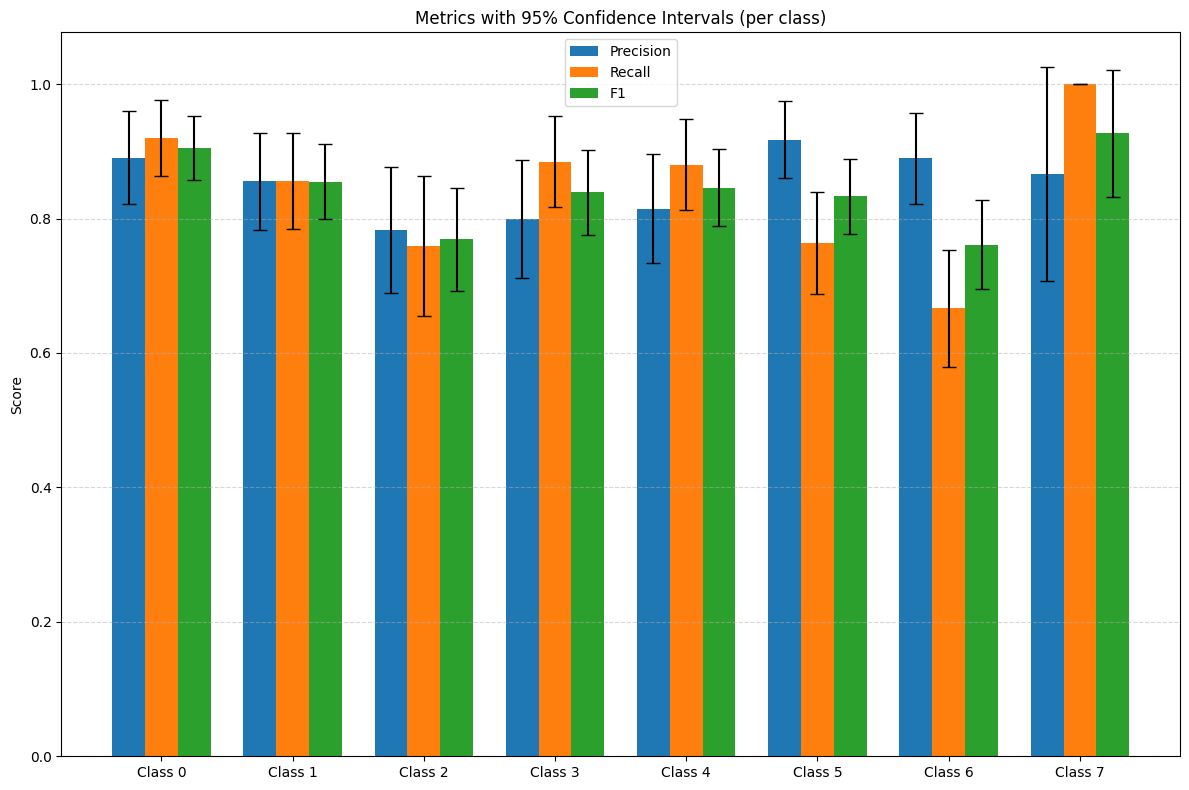

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Собираем данные в DataFrame
metrics = []
for class_id in ci['per_class']:
    for metric in ['precision', 'recall', 'f1']:
        metrics.append({
            'Class': f'Class {class_id}',
            'Metric': metric.capitalize(),
            'Mean': ci['per_class'][class_id][metric]['mean'],
            'CI': ci['per_class'][class_id][metric]['interval']
        })

df = pd.DataFrame(metrics)

# Создаем bar plot с error bars
plt.figure(figsize=(12, 8))
for i, metric in enumerate(['Precision', 'Recall', 'F1']):
    subset = df[df['Metric'] == metric]
    plt.bar(np.arange(len(subset)) + i*0.25, subset['Mean'],
            width=0.25, label=metric, yerr=subset['CI'], capsize=5)

plt.xticks(np.arange(len(ci['per_class'])) + 0.25, [f'Class {i}' for i in ci['per_class']])
plt.ylabel('Score')
plt.title('Metrics with 95% Confidence Intervals (per class)')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score
import numpy as np

def calculate_multilabel_auc(val_labels, val_predictions):
    """
    Вычисляет ROC AUC для мультилейбл классификации

    Параметры:
    val_labels - истинные метки (list или array) с бинарными значениями [0, 1]
    val_predictions - предсказанные вероятности (list или array) в диапазоне [0, 1]

    Возвращает:
    - AUC для каждого класса
    - Средний AUC (macro)
    """
    # Преобразуем в numpy массивы
    val_labels = np.array(val_labels)
    val_predictions = np.array(val_predictions)

    # Проверка размерностей
    assert val_labels.shape == val_predictions.shape
    assert set(np.unique(val_labels)).issubset({0, 1})

    n_classes = val_labels.shape[1]
    auc_scores = []

    for i in range(n_classes):
        try:
            # Для каждого класса вычисляем AUC
            auc = roc_auc_score(val_labels[:, i], val_predictions[:, i])
            auc_scores.append(auc)
            print(f"ROC AUC для класса {i}: {auc:.4f}")
        except ValueError as e:
            print(f"Не удалось вычислить AUC для класса {i}: {str(e)}")
            auc_scores.append(float('nan'))

    # Вычисляем средний AUC (игнорируя NaN)
    mean_auc = np.nanmean(auc_scores)
    print(f"\nСредний ROC AUC (macro): {mean_auc:.4f}")

    return auc_scores, mean_auc

# Пример использования:
# Преобразуем ваши данные в numpy массивы перед вызовом функции
val_labels_array = np.array(val_labels)  # если val_labels - список
val_predictions_array = np.array(val_predictions)  # если val_predictions - список

auc_scores, mean_auc = calculate_multilabel_auc(val_labels_array, val_predictions_array)

ROC AUC для класса 0: 0.9388
ROC AUC для класса 1: 0.9001
ROC AUC для класса 2: 0.8508
ROC AUC для класса 3: 0.9073
ROC AUC для класса 4: 0.9058
ROC AUC для класса 5: 0.8667
ROC AUC для класса 6: 0.8126
ROC AUC для класса 7: 0.9951

Средний ROC AUC (macro): 0.8971


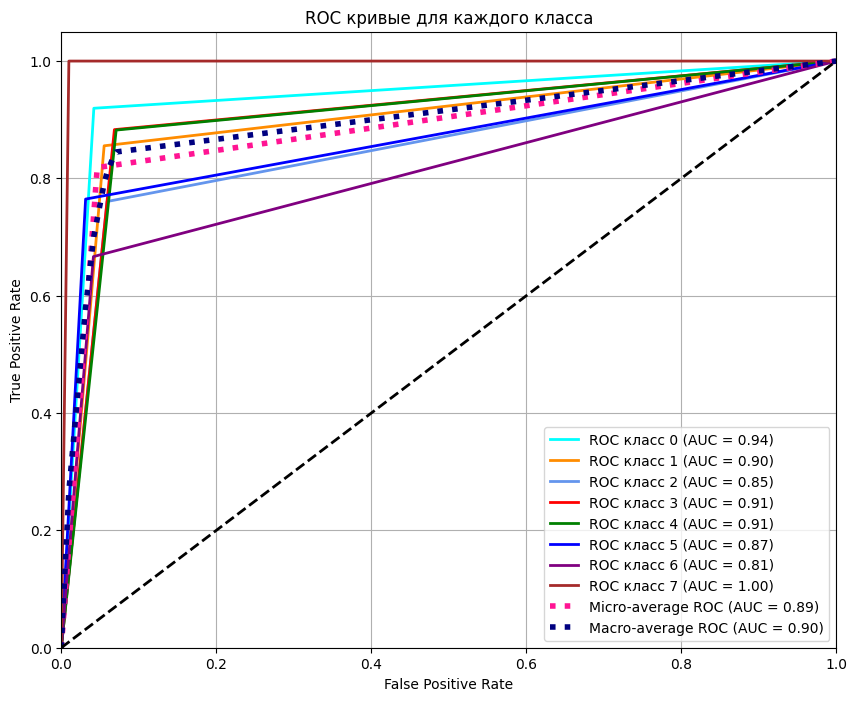

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_multilabel_roc(val_labels, val_predictions, n_classes=8):
    """
    Построение ROC кривых для каждого класса и micro/macro average

    Параметры:
    val_labels - истинные метки (n_samples, n_classes)
    val_predictions - предсказанные вероятности (n_samples, n_classes)
    n_classes - количество классов
    """
    # Преобразуем в numpy массивы если нужно
    val_labels = np.array(val_labels)
    val_predictions = np.array(val_predictions)

    # Инициализация
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Вычисляем ROC для каждого класса
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(val_labels[:, i], val_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(val_labels.ravel(), val_predictions.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Настройка графика
    plt.figure(figsize=(10, 8))
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green',
                   'blue', 'purple', 'brown', 'pink', 'gray'])

    # Кривые для каждого класса
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC класс {0} (AUC = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    # Micro и Macro average
    plt.plot(fpr["micro"], tpr["micro"],
             label='Micro-average ROC (AUC = {0:0.2f})'
             ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='Macro-average ROC (AUC = {0:0.2f})'
             ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    # Диагональ
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC кривые для каждого класса')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    return roc_auc

# Пример использования:
roc_auc_scores = plot_multilabel_roc(val_labels, val_predictions)